# The Max-cut problem.

### Introduction.

The Max-cut problem is a combinatorial problem that can be stated in terms of colouring graphs. Let us suppose we have a graph, and we want two assing one between two colors (let's think in white and black) to any to its nodes in the manner that each white node is be connected as much as possible to black nodes. In other words, the problem consists in the maximization of the number of edges that have ending nodes different-coloured.  

To begin to get some insight in these concepts, lets define a class of Graphs and methods to visualize them:

In [1]:
import networkx as nx                     # Auxiliar Library to define graphs 
from matplotlib import pyplot as plt

In [2]:
class Edge:
    """
    We define the class Edge that has defined tow ending nodes and an associated weight (as defect this is 1)
    """
    def __init__(self, start_node, end_node, weight = 1):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight
        
class Graph():
    """
    Class that defines a Graph as a set of nodes and Edges.
    """
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)


With the aim to watch the working of these clases, we can define and plot an example of a graph:

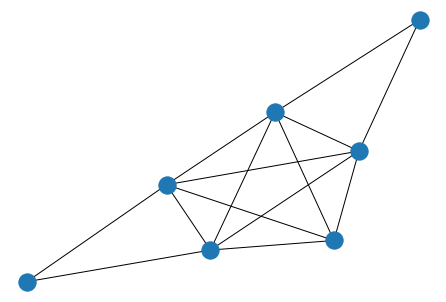

In [3]:
set_edges = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 0), Edge(2, 0), Edge(1, 3), Edge(0, 4), Edge(1, 4),
            Edge(2, 4), Edge(3, 4), Edge(4, 5), Edge(5, 0), Edge(2, 6), Edge(6, 3)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.weight)

nx.draw(G)
plt.show()

In fact, we can also define a method to coloured graphs:

In [4]:
def coloured_Graph(Graph, code):
    """
    Method to plot coloured graphs.
    Params:
    Graph (nx.Graph() object): Graph to be coloured.
    Code (List): binary code to color the Graph
    """
    colors = []
    for i in code:
        if i == 0:
            colors.append('green')
        else:
            colors.append('red')            
            
    pos = nx.spring_layout(Graph, seed = 100)
    nx.draw(Graph, pos, node_color = colors)
    labels = nx.get_edge_attributes(Graph, 'weight')
    nx.draw_networkx_edge_labels(Graph, pos, edge_labels = labels)
    plt.show
    
    return None

Now we can have a coloured Graph with also its respective weights:

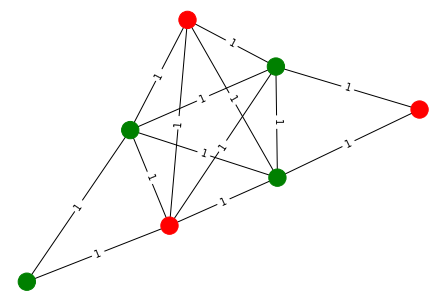

In [5]:
coloured_Graph(G, [0, 1, 0, 1, 0, 1, 0]) 

As we will need binary codes, we write an algorithm to convert decimal numbers to binary ones using a determined number of bits:

In [6]:
def Binary(number, bits):
    """
    Gives the binary representation of number in bits bits
    
    Params:
        number(positive integer) = number to be converted 
        num(positive integer) = number of bits involved
    """
    list = []
    if number == 0:
        for i in range(0, bits):
            list.append(0)
    elif number == 1:
        for i in range(0, bits - 1):
            list.append(0)
        list.append(1)
    elif number == 2:
        for i in range(0, bits - 2):
            list.append(0)
        list.append(1)
        list.append(0)
    else:
        aux_list = []
        aux_number = number
        while aux_number // 2 > 1:
            aux_list.append(aux_number % 2)
            aux_number = aux_number // 2
        aux_list.append(aux_number % 2)
        aux_list.append(1)
        for j in range(0, bits):
            if j < bits - len(aux_list):
                list.append(0)
            else:
                k = j - (bits - len(aux_list))
                list.append(aux_list[len(aux_list) - k - 1])
    return list

This function, for instance, can give us the representation of the decimal number $18$ using $7$ bits:

In [7]:
Binary(18, 7)

[0, 0, 1, 0, 0, 1, 0]

### The QAOA Algorithm

The QAOA (Quantum Approximate Optimization Algorithm) is an algorithm that allows us to solve the Max-cut problem using a circuit-gate implementation. The idea is based on the adiabatic algorithm which states that if we begin with a Hamiltonian and we have a quantum system in the ground state of such Hamiltonian, and then we perform a transformation of such Hamiltonian to another one softly enough, then the quantum state remains at the end in the ground state of the new Hamiltonian. The Max-cut problem has the advantage that its solution is the ground state of the Hamiltonian: $$H=\frac{1}{2}\sum_{ij}w_{ij}\left(Z_{i}Z_{j}-1\right)$$, where $Z_{i}$ is defined as the Pauli-$Z$ gate of the $i-$th qubit (in or implementation we will use a qubit for each node of the graph). We begin with the implementation of the quantum circuit using Cirq:

In [8]:
import cirq                            # Quantum Circuits Library
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize    # Optimization Library

num = 5      # Number of qubits to be used in the circuit
depth = 50   # Number of Repetitions of the Suzuki-Trotter Algorithm
rep = 10000  # Number of Quantum runs to get the statistics of measurements of the Quantum Circuit
set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 2), Edge(3, 4, 3)]

qubits = [cirq.GridQubit(0, i) for i in range(0, num)] # List of Qubits



def initialization(qubits):
    """
    Initialization of the qubits in an equal superposition of the computational basis (ground state of the auxiliar Hamiltonian)
    Params:
    
    qubits(list of qubits object)
    """
    for i in qubits:
        yield cirq.H.on(i)

Now, we can define the time evolution operators of the Cost Hamiltonian and the Auxiliar Hamiltonian:

In [9]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZPowGate(exponent = -1 * i.weight * gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])

# Defines the mixer unitary

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent = -1 * alpha/math.pi).on(qubits[i])

After this, we can create a function that executes our circuit over multiple trials, and outputs lists of the bitstrings that were measured:

In [10]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[2 * i] for i in range(0, depth)]
    alpha = [params[2 * i  + 1] for i in range(0, depth)]
    
    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))
#    print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

Now, we are able to create our cost function, in order to post-process the data measured from the quantum circuit executions. Since the values that are ouputted from the circuit are $0$s and $1$s, instead of the desired $1$ and $-1$ values. Thus, in the place of $c_{n}$, we defined a function $f(x)=1-2x$, which maps $0$ to $1$ and $1$ to $-1$:

In [11]:
# Defines the cost function

def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += 0.5 * j.weight * ( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

#    print("Cost: "+str(total_cost))

    return total_cost

This function outputs the expected value of the cost function (calculate the average cost over $1000$ repetitions of the algorithm). Finally, we can define a classical optimizer to tune the $\gamma$ and $\alpha$ parameter until we arrive at a minimum expected value of the cost function. Along with the cost function, we write a bit of code that allows us to graph the results:

     fun: -17.5812
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 500
  status: 2
 success: False
       x: array([ 2.4330588 , -2.62845556, -1.36091334, -3.07419749, -0.34659372,
       -0.81966668, -2.57376883, -2.65355786,  0.77883162,  0.65835617,
        0.31453083, -1.87073122,  2.03087947, -1.29812842, -0.63864927,
       -0.05455001,  0.98234185, -2.69969756, -2.90085653, -2.36272586,
       -2.91248772, -2.12627392, -2.03709538,  0.52643914,  0.18108136,
        0.04084482, -0.10862168,  3.11149481,  1.07616656, -0.78421104,
       -0.11133879,  2.01028402,  0.17743082, -2.19032787, -1.99397755,
       -1.92100431, -2.44646788,  2.1254927 , -1.26107397, -2.80017316,
       -0.24423485,  0.10770799,  1.10141626, -2.36238833,  1.2389139 ,
       -0.10041165,  1.63565952,  2.94689012, -0.9163417 ,  1.59868771,
        1.0296504 , -0.44440029, -2.43089805, -0.58312685, -3.05031384,
       -2.28935568, -1.8636314 , -1.70272707, -2.8311

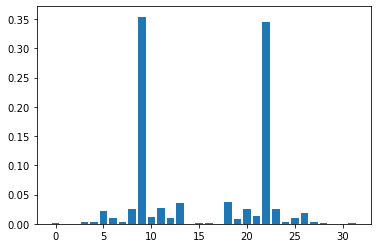

In [12]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 2 * depth)]
out = minimize(cost_function,
               x0 = init, 
               method = "COBYLA", 
               options = {'maxiter' : 500}
              )
#print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()

In [13]:
max_value = max(y)
max_value = y.index(max_value)

In [14]:
G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.weight)

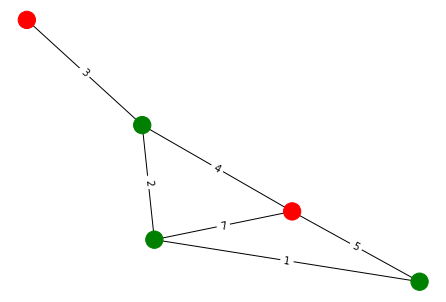

In [20]:
coloured_Graph(G, Binary(max_value, num))